# Churn prediction

In [220]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

In [221]:
path = "https://raw.githubusercontent.com/ekaratnida/Automated_Tools-/keep/Mini-bads3/cust_churn.csv"
df = pd.read_csv(path)
df.head()

,CUST_CODE,FEB_VISIT,FEB_PRODUCT,FEB_STORE,MAR_CHURN
0,CUST0000026911,3,8,1,0
1,CUST0000092645,5,46,2,0
2,CUST0000109188,1,22,1,0
3,CUST0000128103,1,2,1,0
4,CUST0000281089,5,14,1,0


# List churned cust

# Sorted feb store

In [222]:
df.FEB_STORE.sort_values(ascending=False)

233     8
1483    7
1226    6
576     6
1780    6
       ..
1621    1
1624    1
1625    1
1628    1
0       1
Name: FEB_STORE, Length: 2771, dtype: int64

0    2700
1      71
Name: MAR_CHURN, dtype: int64


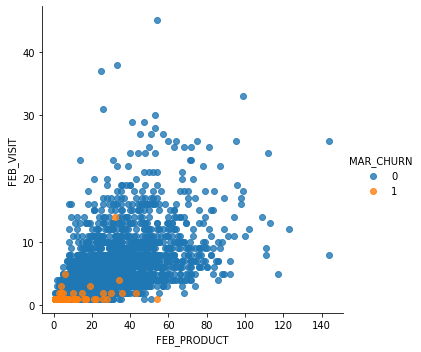

In [223]:
import seaborn as sns

ax = sns.lmplot( x="FEB_PRODUCT", y="FEB_VISIT", data=df, fit_reg=False, hue='MAR_CHURN', legend=True)
print(df['MAR_CHURN'].value_counts())

In [224]:
x = df.iloc[:,1:-1]
x.head(5)

,FEB_VISIT,FEB_PRODUCT,FEB_STORE
0,3,8,1
1,5,46,2
2,1,22,1
3,1,2,1
4,5,14,1


In [225]:
y = df.iloc[:,-1:]
y.head(5)

,MAR_CHURN
0,0
1,0
2,0
3,0
4,0


In [226]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) #imbalanced data

print(y_train.value_counts())
print(y_test.value_counts())

MAR_CHURN
0            2159
1              57
dtype: int64
MAR_CHURN
0            541
1             14
dtype: int64


In [227]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
#clf.feature_importances_
#clf.get_depth()
#clf.get_n_leaves()

# Visualization 1

In [228]:
#import graphviz 
#dot_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=x_train.columns) 
#graph = graphviz.Source(dot_data) 
##graph.render("churn") #This line will produce pdf file
#graph #This line will show graph on colab

# Visualization 2

In [229]:
!pip install dtreeviz

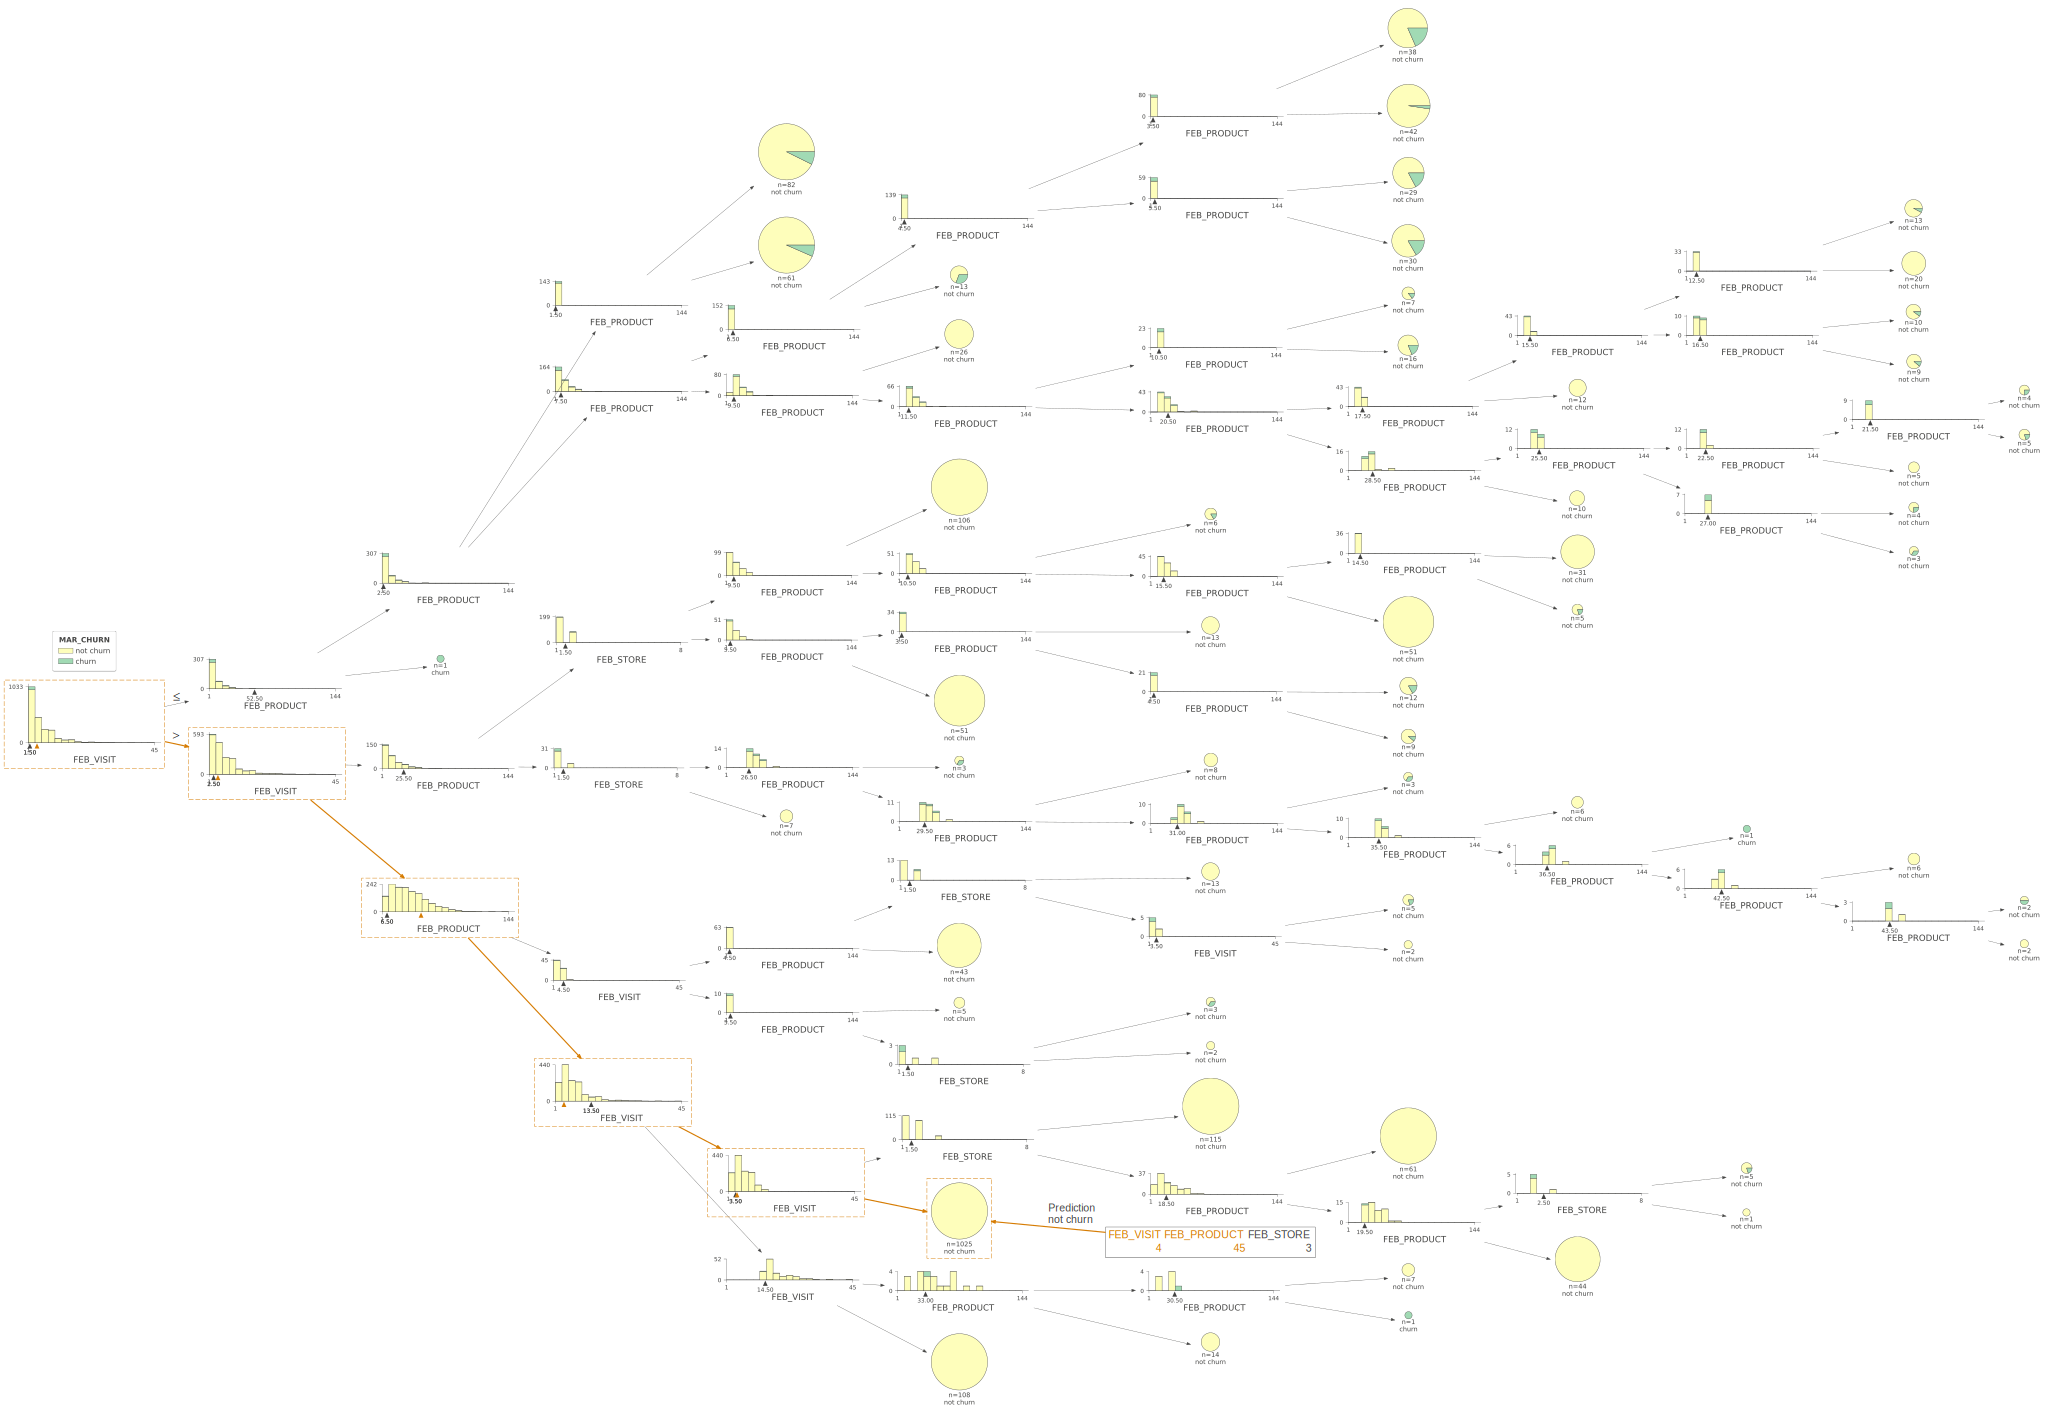

In [230]:
from dtreeviz.trees import *

viz = dtreeviz(clf, 
               x_train.values, 
               y_train['MAR_CHURN'],
               target_name='MAR_CHURN',
               feature_names= ["FEB_VISIT","FEB_PRODUCT","FEB_STORE"],
               class_names=["not churn","churn"],
               orientation ='LR',
               X=x_test.iloc[0,:]
              )  
              
viz#.save("output.svg")

# Confusion matrix

In [231]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(x_test) 
print(y_pred.shape)
print(y_pred.sum())
#print(sum(y_pred>0))
print("y_test")
print(y_test.value_counts())

confusion_matrix_train = confusion_matrix(y_test, y_pred)
print(confusion_matrix_train)

TruePositive = confusion_matrix_train[1,1]
print("TP=",TruePositive)
FalseNegative = confusion_matrix_train[1,0]
print("FN=",FalseNegative)

TrueNegative = confusion_matrix_train[0,0]
print("TN=",TrueNegative)
FalsePositive = confusion_matrix_train[0,1]
print("FP=",FalsePositive)

from sklearn.metrics import classification_report

target_names = ['not churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

(555,)
0
y_test
MAR_CHURN
0            541
1             14
dtype: int64
[[541   0]
 [ 14   0]]
TP= 0
FN= 14
TN= 541
FP= 0
              precision    recall  f1-score   support

   not churn       0.97      1.00      0.99       541
       churn       0.00      0.00      0.00        14

    accuracy                           0.97       555
   macro avg       0.49      0.50      0.49       555
weighted avg       0.95      0.97      0.96       555



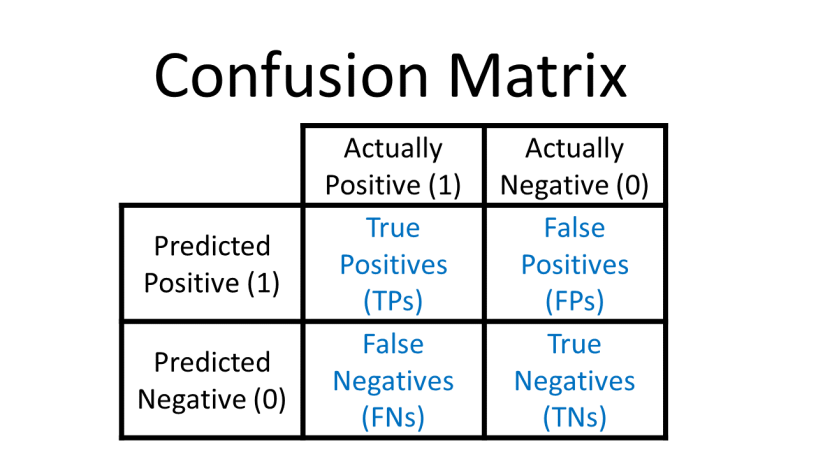

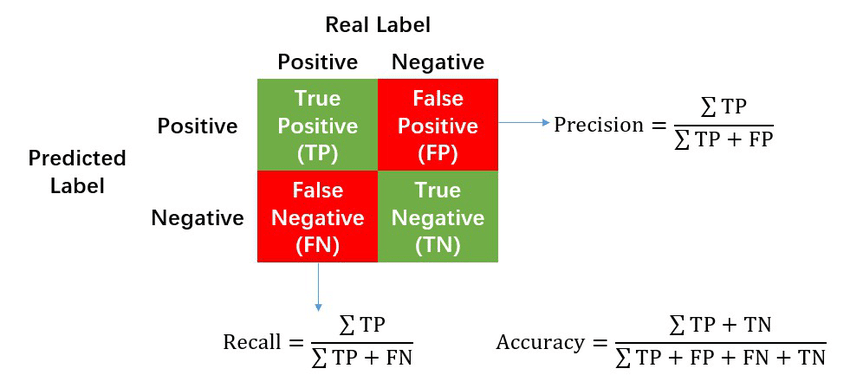

### Can we improve the efficiency of prediction?
### Apply negative downsampling

In [232]:
y_train_pos = y_train[y_train['MAR_CHURN']==1]
print(y_train_pos.shape)
y_train_neg = y_train[y_train['MAR_CHURN']==0]
print(y_train_neg.shape)

y_train_neg = y_train_neg.sample(int(y_train_neg.shape[0] * 0.2), random_state=42)
print("down ", y_train_neg.shape)
y_train_new = pd.concat([y_train_pos, y_train_neg])
x_train_new = x_train.loc[y_train_new.index]
print(x_train_new)
#y_train_new.value_counts()

(57, 1)
(2159, 1)
down  (431, 1)
      FEB_VISIT  FEB_PRODUCT  FEB_STORE
241           1            5          1
2419          1           54          1
539           1            1          1
548           1            3          1
2630          1            2          1
...         ...          ...        ...
1747         11           66          2
538          14           79          1
710          11           26          5
938           5            8          2
2275          4           16          1

[488 rows x 3 columns]


In [233]:
clf = tree.DecisionTreeClassifier(random_state = 42)
clf = clf.fit(x_train_new, y_train_new)

In [234]:
y_pred = clf.predict(x_test)

confusion_matrix_train = confusion_matrix(y_test, y_pred)
print(confusion_matrix_train)

TruePositive = confusion_matrix_train[1,1]
print("TP = ", TruePositive)

FalsePositive = confusion_matrix_train[1,0]
print("FP = ", FalsePositive)

TrueNegative = confusion_matrix_train[0,0]
print("TN = ", TrueNegative)

FalseNegative = confusion_matrix_train[0,1]
print("FN = ", FalseNegative)

target_names = ['not churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

[[512  29]
 [ 11   3]]
TP =  3
FP =  11
TN =  512
FN =  29
              precision    recall  f1-score   support

   not churn       0.98      0.95      0.96       541
       churn       0.09      0.21      0.13        14

    accuracy                           0.93       555
   macro avg       0.54      0.58      0.55       555
weighted avg       0.96      0.93      0.94       555



<H1> More technique: post pruning

In [235]:
clf = tree.DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(x_train_new, y_train_new)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
print(impurities)

[0.         0.00013661 0.00016062 0.00028461 0.00034153 0.00034153
 0.00054645 0.00062096 0.00068306 0.00087822 0.00091075 0.00100883
 0.00101217 0.00145855 0.00161007 0.00182149 0.00200199 0.00222432
 0.00232861 0.00237264 0.00264945 0.00291199 0.00328606 0.00411893
 0.04017501]
[0.09499685 0.09513346 0.09529408 0.09557868 0.09592021 0.09660327
 0.09714972 0.09901261 0.10106179 0.10194001 0.10285076 0.10486841
 0.11499012 0.11790721 0.12112736 0.12659184 0.13059581 0.13504446
 0.14668753 0.14906017 0.15170961 0.1546216  0.15790766 0.16614553
 0.20632055]


In [236]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train_new, y_train_new)
    clfs.append(clf)

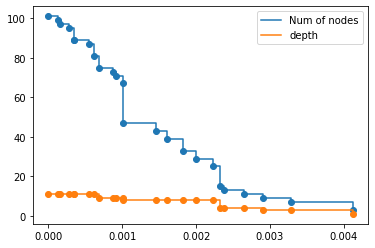

In [237]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='Num of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

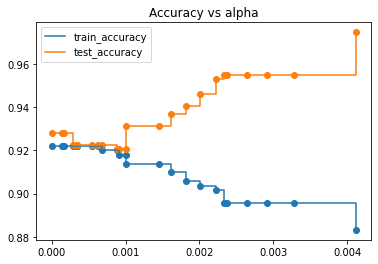

In [238]:
from sklearn.metrics import accuracy_score
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train_new)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train_new))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [239]:
clf = tree.DecisionTreeClassifier(random_state=42,ccp_alpha=0.001)
clf.fit(x_train_new, y_train_new)
y_pred = clf.predict(x_test)
#print(y_test)

confusion_matrix_train = confusion_matrix(y_test, y_pred)
print(confusion_matrix_train)

TruePositive = confusion_matrix_train[1,1]
print("TP = ", TruePositive)

FalsePositive = confusion_matrix_train[1,0]
print("FP = ", FalsePositive)

TrueNegative = confusion_matrix_train[0,0]
print("TN = ", TrueNegative)

FalseNegative = confusion_matrix_train[0,1]
print("FN = ", FalseNegative)

target_names = ['not churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))


[[507  34]
 [ 10   4]]
TP =  4
FP =  10
TN =  507
FN =  34
              precision    recall  f1-score   support

   not churn       0.98      0.94      0.96       541
       churn       0.11      0.29      0.15        14

    accuracy                           0.92       555
   macro avg       0.54      0.61      0.56       555
weighted avg       0.96      0.92      0.94       555



# How about randomforest

In [240]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=2521)
clf.fit(x_train_new, y_train_new)
y_pred = clf.predict(x_test)
#print(y_test)

confusion_matrix_train = confusion_matrix(y_test, y_pred)
print(confusion_matrix_train)

TruePositive = confusion_matrix_train[1,1]
print("TP = ", TruePositive)

FalsePositive = confusion_matrix_train[1,0]
print("FP = ", FalsePositive)

TrueNegative = confusion_matrix_train[0,0]
print("TN = ", TrueNegative)

FalseNegative = confusion_matrix_train[0,1]
print("FN = ", FalseNegative)

target_names = ['not churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

[[518  23]
 [ 10   4]]
TP =  4
FP =  10
TN =  518
FN =  23
              precision    recall  f1-score   support

   not churn       0.98      0.96      0.97       541
       churn       0.15      0.29      0.20        14

    accuracy                           0.94       555
   macro avg       0.56      0.62      0.58       555
weighted avg       0.96      0.94      0.95       555

